<h1 style="font-size:32px; color:Black;">Step 6: Hyperparameter Tuning</h1>

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

# Train Initial Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

 Hyperparameter Tuning with RandomizedSearchCV

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

Tuned Random Forest Evaluation:
RMSE: 360.85
R² Score: -0.36


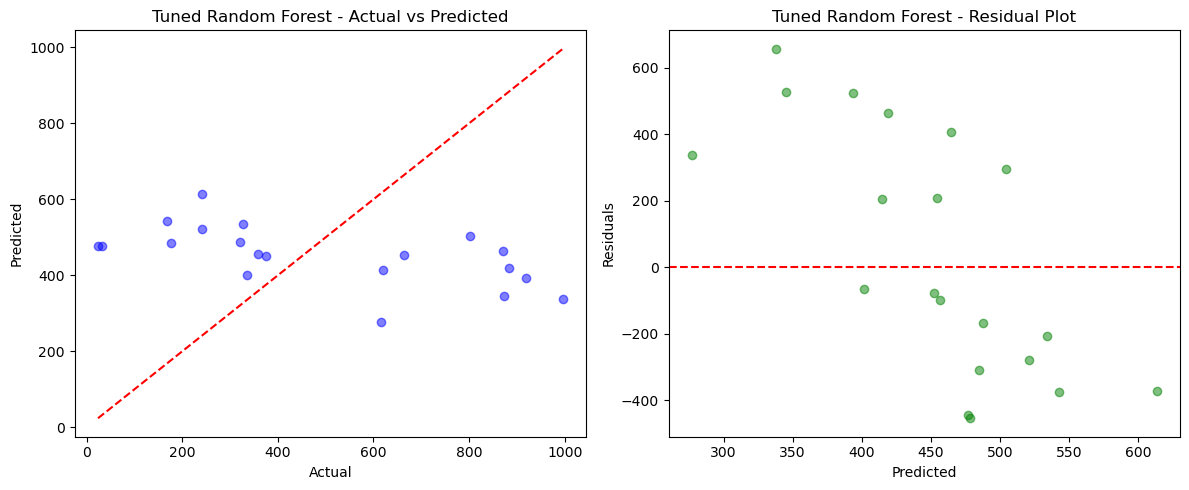

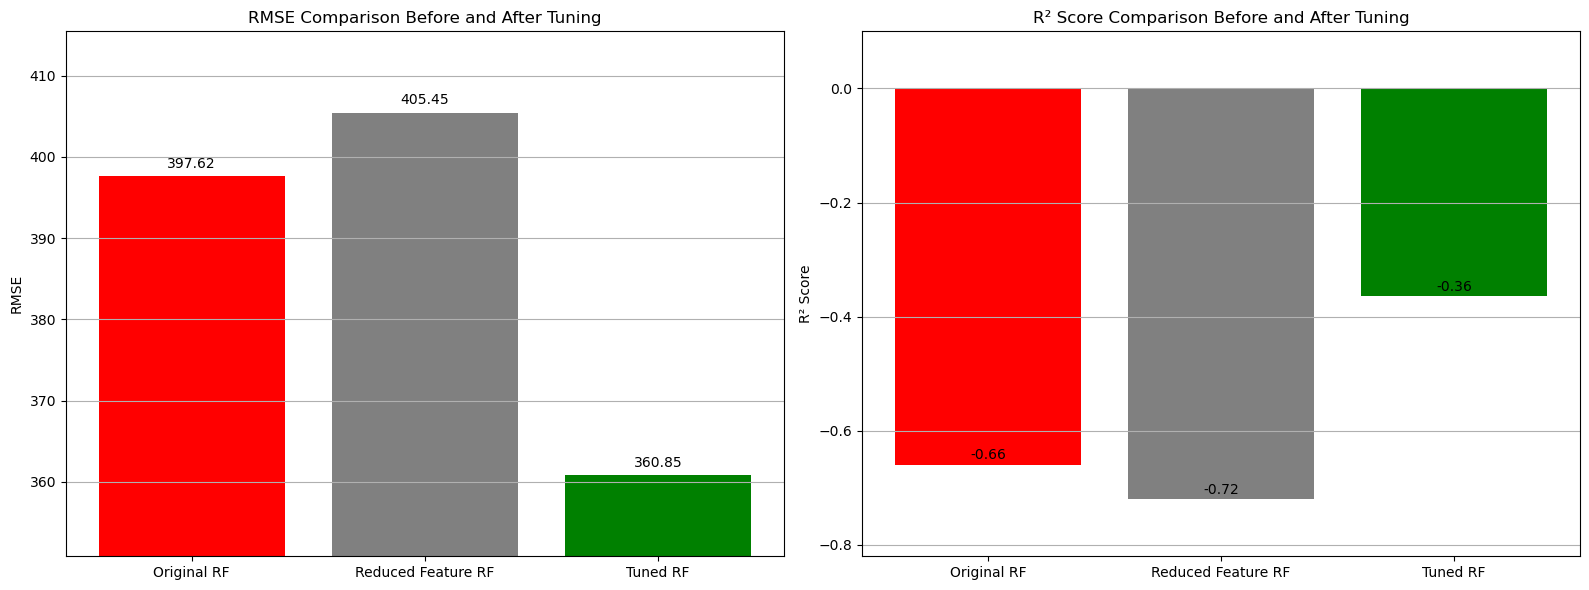

In [16]:
# --- Fit/train/test sets must be defined before this (X_train, X_test, y_train, y_test) ---

# --- Define Parameter Grid ---
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # 'auto' removed (deprecated)
    'bootstrap': [True, False]
}

# --- Base Model ---
rf_base = RandomForestRegressor(random_state=42)

# --- Randomized Search CV ---
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# --- Fit the Model ---
random_search.fit(X_train, y_train)

# --- Best Estimator ---
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# --- Predict on Test Set ---
y_pred_tuned = best_rf.predict(X_test)

# --- Evaluation Function ---
def evaluate_model(name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    plt.figure(figsize=(12, 5))

    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")

    # Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{name} - Residual Plot")

    plt.tight_layout()
    plt.savefig(f"{name.replace(' ', '_')}_evaluation_plot.png")
    plt.show()
    
    return rmse, r2

# --- Evaluate and Save Model ---
rmse_tuned, r2_tuned = evaluate_model("Tuned Random Forest", y_test, y_pred_tuned)
joblib.dump(best_rf, 'tuned_random_forest_model.pkl')

# --- Comparison Values ---
models = ['Original RF', 'Reduced Feature RF', 'Tuned RF']
rmse_values = [397.62, 405.45, rmse_tuned]
r2_values = [-0.66, -0.72, r2_tuned]

# --- Combined RMSE & R² Comparison Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- RMSE Plot ---
axes[0].bar(models, rmse_values, color=['red', 'gray', 'green'])
axes[0].set_title('RMSE Comparison Before and After Tuning')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(min(rmse_values) - 10, max(rmse_values) + 10)
axes[0].grid(axis='y')
for i, value in enumerate(rmse_values):
    axes[0].text(i, value + 1, f'{value:.2f}', ha='center')

# --- R² Score Plot ---
axes[1].bar(models, r2_values, color=['red', 'gray', 'green'])
axes[1].set_title('R² Score Comparison Before and After Tuning')
axes[1].set_ylabel('R² Score')
axes[1].set_ylim(min(r2_values) - 0.1, 0.1)
axes[1].grid(axis='y')
for i, value in enumerate(r2_values):
    axes[1].text(i, value + 0.01, f'{value:.2f}', ha='center')

# Save combined figure
plt.tight_layout()
plt.savefig("rmse_r2_comparison_plot.png", dpi=300, bbox_inches='tight')
plt.show()
